Data obtained from project "abstract"
```python
epochs[-1].get_data().shape # The Epochs object of the last subject in numpy array

e = epochs[-1][["img","sf","toon"]]

X = e.get_data()[:,:28,:]
Y = get_labels_from_events(e.events, e.event_id)

X.shape

assert X.shape[0] == Y.shape[0]

with open("subj28.pkl", "wb") as f:
    pickle.dump(epochs[-1], f, protocol=pickle.HIGHEST_PROTOCOL)
```



.File "subj28.pkl" is a pickled tuple of two numpy arrays: X and Y. X has shape (797 epochs, 28 channels, 501 samples) and Y has shape (797, 4). It is three experimental categories and five affective classes one-hot-encoded into 4 dimensions. 

```python
    m = {"0": np.array([ 0, 0]),
        "1": np.array([ 1, 1]),
        "2": np.array([-1, 1]),
        "3": np.array([-1,-1]),
        "4": np.array([ 1,-1])}
    c = {"img": np.array([0, 0]),
        "sf":   np.array([1, 0]),
        "toon": np.array([0, 1])}
```

In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mne

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import torch
from torch import nn
import torch.nn.functional as F
import torchmetrics

In [2]:
with open("ex/subj28.pkl", 'rb') as f:
    X,Y = pickle.load(f)
print(X.shape)
print(Y.shape)

(797, 28, 501)
(797, 4)


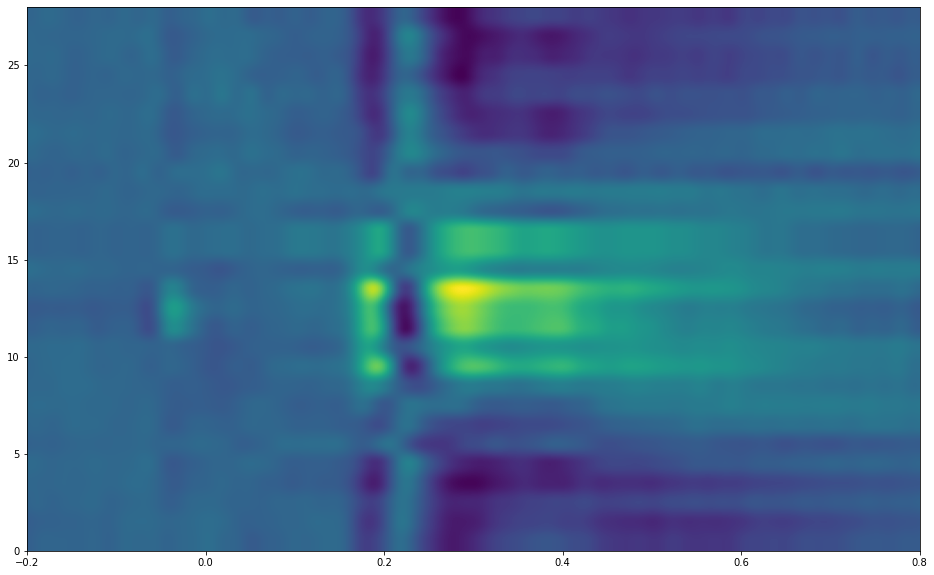

In [3]:
fs = 500
tmin = -0.200
tmax = 0.800
ch_names = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
t = np.linspace(tmin, tmax, X.shape[2])
fig, ax = plt.subplots(figsize=(16,10))
ax.imshow(X.mean(axis=0), extent=[tmin, tmax,0,28], interpolation=None)
ax.set_aspect("auto")
plt.show()

Simplest attempt, every sample in every channel is a variable observed on every trial.

In [4]:
n_channels = X.shape[1]
n_samples = X.shape[2]
X = X.reshape(797,-1)
print(X.shape)

(797, 14028)


In [5]:
Y = Y[:,:2].astype("int")
print(Y.shape)
print(f"Category IMG {sum((Y == [0, 0]).all(axis=1))}")
print(f"Category IMG {sum((Y == [1, 0]).all(axis=1))}")
print(f"Category IMG {sum((Y == [0, 1]).all(axis=1))}")

(797, 2)
Category IMG 263
Category IMG 271
Category IMG 263


(797, 14028)


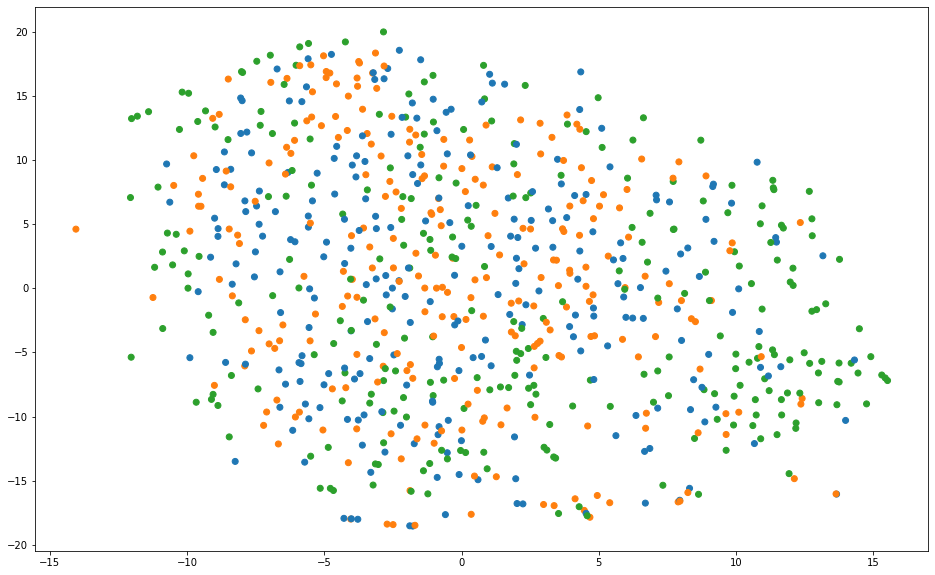

In [6]:
print(X.shape)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
fig = plt.figure(figsize=(16,10))
cmap = plt.cm.get_cmap('tab10')
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=cmap([a*2 + b for a,b in Y[:,:2]]))
# plt.legend()

The features don't seem to be linearly separable, so a high accuracy is not expected.

In [7]:
X = X.reshape(797,n_channels,n_samples)[:,None,:,:]

Pytorch loss function uses the Y vector with categories encoded as numbers.

In [8]:
n_classes = Y.shape[1]
print(n_classes)
Y_ = np.zeros(Y.shape[0])
Y_[(Y == [0, 0]).all(axis=1)] = 0
Y_[(Y == [1, 0]).all(axis=1)] = 1
Y_[(Y == [0, 1]).all(axis=1)] = 2
Y = Y_
print(Y.shape)

2
(797,)


A 70/30 split is done for testing and training purposes. This evaluates the model's generalizability.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

## The model

In [10]:
from torch.autograd import Variable
accuracy = torchmetrics.Accuracy()


class CommonSpatialFilter(nn.Module):
    """The model implements a CSP-like network for BCI applications

    Parameters
    ----------
    spatial_dim : int
        Number of channels
    n_components : int
        The number of spatial filters.
    """
    def __init__(self, n_channels, n_classes, n_components=5):
        super(CommonSpatialFilter, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_components = n_components

        # define model architecture
        self.spatial_filtering = nn.Conv2d(
            1, self.n_components, (n_channels, 1), bias=False)

        self.classifier = nn.Sequential(
            nn.Linear(n_components, n_classes),
            nn.LogSoftmax(dim=1),
        )


    def forward(self, x):
        x = self.spatial_filtering(x)
        x = torch.sum(x ** 2, dim=(2,3)) # Sum along empty dimension
        x = torch.log(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
   
    def init(self, init_func, *params, **kwargs):
        for p in self.parameters():
            init_func(p, *params, **kwargs)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"
print('Using device:', device)

Using device: cuda


In [12]:
n_channels = 28 
n_classes = 3
learningRate = 0.001 
epochs = 500
n_components = 5
model = CommonSpatialFilter(n_channels, n_classes=n_classes, n_components=n_components)
model.to(device)

CommonSpatialFilter(
  (spatial_filtering): Conv2d(1, 5, kernel_size=(28, 1), stride=(1, 1), bias=False)
  (classifier): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [13]:
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
accuracy.to(device)

ltr_curve, atr_curve = [], []
lts_curve, ats_curve = [], []
model.init(nn.init.uniform_)
for epoch in range(epochs):
    # Train Set
    inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
    labels = Variable(torch.tensor(y_train.astype(np.float32))).to(device)

    optimizer.zero_grad()
    inputs = inputs
    y_hat = model(inputs)

    loss = criterion(y_hat, labels.long())
    train_loss = loss.item()
    ltr_curve.append(train_loss)
    
    train_acc = accuracy(y_hat, labels.int())
    atr_curve.append(train_acc.cpu().detach().numpy())
    
    # Optimization
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        # Test set    
        y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
        test_lbls = Variable(torch.tensor(y_test.astype(np.float32))).to(device)
        test_loss = criterion(y_hat, test_lbls.long())
        test_loss = test_loss.item()
        lts_curve.append(test_loss)
        test_acc = accuracy(y_hat, test_lbls.int())
        ats_curve.append(test_acc.cpu().detach().numpy())


    print(f"epoch {epoch}, loss {loss.item()}, Acc_tst: {ats_curve[-1]}") # 

epoch 0, loss 10.104721069335938, Acc_tst: 0.3375000059604645
epoch 1, loss 9.14095401763916, Acc_tst: 0.3375000059604645
epoch 2, loss 8.177754402160645, Acc_tst: 0.3375000059604645
epoch 3, loss 7.216175556182861, Acc_tst: 0.3375000059604645
epoch 4, loss 6.2606520652771, Acc_tst: 0.3375000059604645
epoch 5, loss 5.328819751739502, Acc_tst: 0.3375000059604645
epoch 6, loss 4.48195743560791, Acc_tst: 0.3375000059604645
epoch 7, loss 3.853050470352173, Acc_tst: 0.34166666865348816
epoch 8, loss 3.486886978149414, Acc_tst: 0.2916666567325592
epoch 9, loss 3.2259809970855713, Acc_tst: 0.32499998807907104
epoch 10, loss 2.9803719520568848, Acc_tst: 0.34583333134651184
epoch 11, loss 2.736760139465332, Acc_tst: 0.34583333134651184
epoch 12, loss 2.4944889545440674, Acc_tst: 0.34583333134651184
epoch 13, loss 2.2546956539154053, Acc_tst: 0.34583333134651184
epoch 14, loss 2.0198426246643066, Acc_tst: 0.34583333134651184
epoch 15, loss 1.7946323156356812, Acc_tst: 0.34583333134651184
epoch 1

epoch 131, loss 1.1176263093948364, Acc_tst: 0.2958333194255829
epoch 132, loss 1.11759614944458, Acc_tst: 0.2958333194255829
epoch 133, loss 1.1175663471221924, Acc_tst: 0.2958333194255829
epoch 134, loss 1.117536187171936, Acc_tst: 0.2958333194255829
epoch 135, loss 1.1175060272216797, Acc_tst: 0.2958333194255829
epoch 136, loss 1.1174761056900024, Acc_tst: 0.2958333194255829
epoch 137, loss 1.1174464225769043, Acc_tst: 0.2958333194255829
epoch 138, loss 1.117416501045227, Acc_tst: 0.2958333194255829
epoch 139, loss 1.117386817932129, Acc_tst: 0.2958333194255829
epoch 140, loss 1.117356777191162, Acc_tst: 0.2958333194255829
epoch 141, loss 1.1173268556594849, Acc_tst: 0.2958333194255829
epoch 142, loss 1.1172971725463867, Acc_tst: 0.2958333194255829
epoch 143, loss 1.1172674894332886, Acc_tst: 0.2958333194255829
epoch 144, loss 1.1172374486923218, Acc_tst: 0.2958333194255829
epoch 145, loss 1.1172078847885132, Acc_tst: 0.2958333194255829
epoch 146, loss 1.117178201675415, Acc_tst: 0.

epoch 266, loss 1.1137620210647583, Acc_tst: 0.2958333194255829
epoch 267, loss 1.1137348413467407, Acc_tst: 0.2958333194255829
epoch 268, loss 1.113707423210144, Acc_tst: 0.2958333194255829
epoch 269, loss 1.1136800050735474, Acc_tst: 0.2916666567325592
epoch 270, loss 1.1136529445648193, Acc_tst: 0.2916666567325592
epoch 271, loss 1.1136257648468018, Acc_tst: 0.2916666567325592
epoch 272, loss 1.1135984659194946, Acc_tst: 0.2916666567325592
epoch 273, loss 1.113571286201477, Acc_tst: 0.2916666567325592
epoch 274, loss 1.113544225692749, Acc_tst: 0.2916666567325592
epoch 275, loss 1.1135172843933105, Acc_tst: 0.2916666567325592
epoch 276, loss 1.113490104675293, Acc_tst: 0.2916666567325592
epoch 277, loss 1.1134629249572754, Acc_tst: 0.2916666567325592
epoch 278, loss 1.1134361028671265, Acc_tst: 0.2916666567325592
epoch 279, loss 1.1134088039398193, Acc_tst: 0.2916666567325592
epoch 280, loss 1.1133819818496704, Acc_tst: 0.2916666567325592
epoch 281, loss 1.1133548021316528, Acc_tst:

epoch 401, loss 1.1102451086044312, Acc_tst: 0.2916666567325592
epoch 402, loss 1.110220193862915, Acc_tst: 0.2916666567325592
epoch 403, loss 1.1101953983306885, Acc_tst: 0.2916666567325592
epoch 404, loss 1.1101704835891724, Acc_tst: 0.2916666567325592
epoch 405, loss 1.1101460456848145, Acc_tst: 0.2916666567325592
epoch 406, loss 1.1101210117340088, Acc_tst: 0.2916666567325592
epoch 407, loss 1.1100960969924927, Acc_tst: 0.2916666567325592
epoch 408, loss 1.1100711822509766, Acc_tst: 0.2916666567325592
epoch 409, loss 1.1100462675094604, Acc_tst: 0.2916666567325592
epoch 410, loss 1.110021710395813, Acc_tst: 0.2916666567325592
epoch 411, loss 1.1099971532821655, Acc_tst: 0.2916666567325592
epoch 412, loss 1.109972357749939, Acc_tst: 0.2916666567325592
epoch 413, loss 1.109947681427002, Acc_tst: 0.2916666567325592
epoch 414, loss 1.1099233627319336, Acc_tst: 0.2916666567325592
epoch 415, loss 1.1098982095718384, Acc_tst: 0.2916666567325592
epoch 416, loss 1.10987389087677, Acc_tst: 0

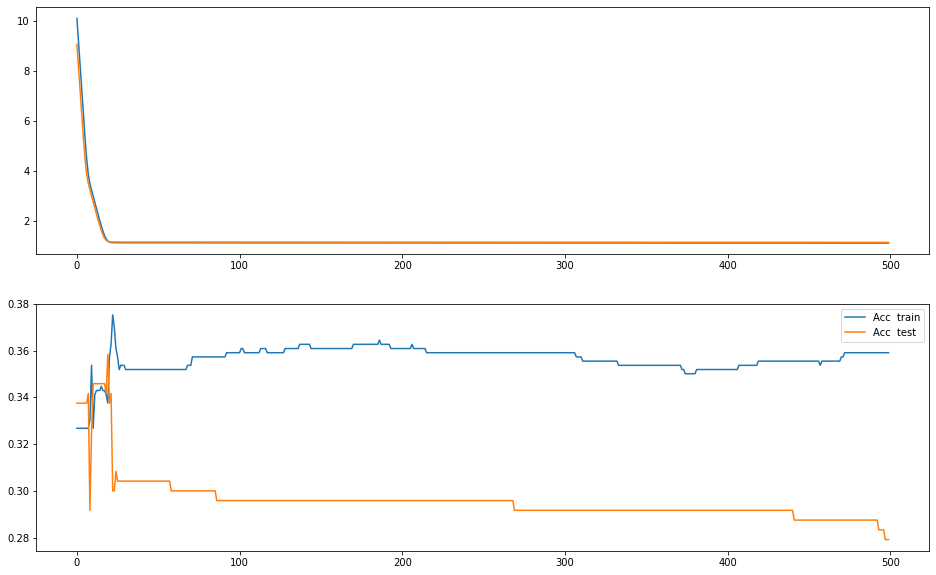

In [14]:
fig, axs = plt.subplots(2, figsize=(16,10))
axs[0].plot(ltr_curve, label="Loss train")
axs[1].plot(atr_curve, label="Acc  train")
axs[0].plot(lts_curve, label="Loss test")
axs[1].plot(ats_curve, label="Acc  test")
# axs[0].set_ylim((0,2))
plt.legend()
plt.show()

# Visualization

In [15]:
coef = [p.cpu().detach().numpy() for p in model.parameters()]
print(len(coef))
print(coef[0].shape)
print(coef[1].shape)
print(coef[2].shape)

3
(5, 1, 28, 1)
(3, 5)
(3,)


In [16]:
print(coef[0].shape)
W = coef[0].squeeze()
print(W.shape)

(5, 1, 28, 1)
(5, 28)


3 CSPs have been learned from the data 

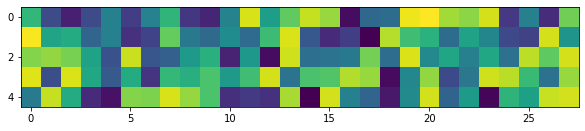

In [17]:
fig = plt.figure(figsize=(10,10))
plt.imshow(W)

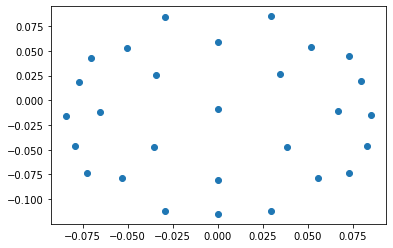

In [18]:
from mne.viz import plot_topomap
layout = mne.channels.make_standard_montage('standard_1020').get_positions()["ch_pos"]
chs = ['Fp1', 'Fz', 'F3', 'F7', 'FC5', 'FC1', 'Cz', 
       'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'Pz', 
       'O1', 'Oz', 'O2', 'P4', 'P8', 'CP6', 'CP2', 
       'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'Fp2']
pos = np.vstack([layout[i] for i in chs])
plt.scatter(pos[:,0], pos[:,1])
plt.show()

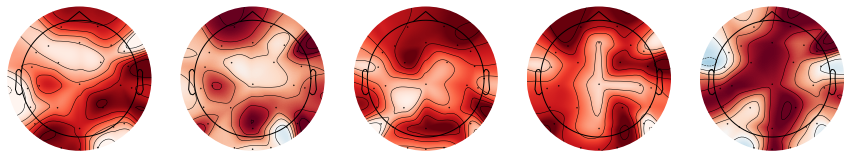

In [19]:
fig, axs = plt.subplots(1,n_components, figsize=(15,7))
for i in range(n_components):
    plot_topomap(W[i,:], pos[:,:2], axes=axs[i], show=False)
fig.show()

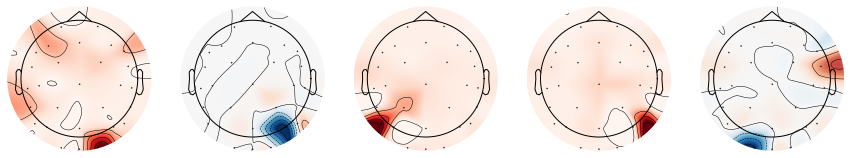

In [20]:
fig, axs = plt.subplots(1,n_components, figsize=(15,7))
for i in range(n_components):
    plot_topomap(1/(W[i,:]), pos[:,:2], axes=axs[i], show=False)
fig.show()

In [21]:
X_embedded = model.spatial_filtering(Variable(torch.tensor(X.astype(np.float32))).to(device)).cpu().detach().numpy()
X_embedded = X_embedded.squeeze()
print(X_embedded.shape)

(797, 5, 501)


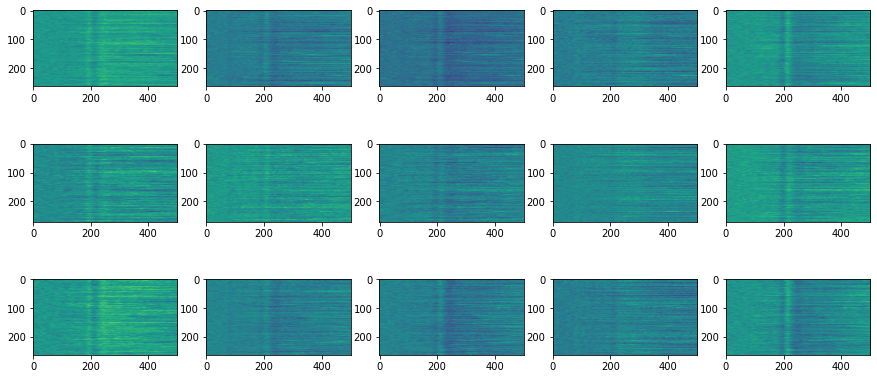

In [22]:
fig, axs = plt.subplots(n_classes, n_components, figsize=(15,7))
for i in range(n_classes):
    for j in range(n_components):
        axs[i,j].imshow(X_embedded[Y==i,j,:])

# Cross-validation

In [23]:
from sklearn.model_selection import KFold

n_channels = 28 
n_classes = 3
learningRate = 0.001 
n_components = 20
epochs = 200 # Early stopping.
accuracy.to(device)


kf = KFold(n_splits=5)
kf.get_n_splits(X)

print(kf)

KFold(n_splits=5, random_state=None, shuffle=False)


In [24]:
def train_model(X_train, Y_train, X_test, Y_test):

    model = CommonSpatialFilter(n_channels, n_classes=n_classes, n_components=n_components)
    model.to(device)
    
#     criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
    
    model.init(nn.init.uniform_)
    ltr_curve, atr_curve = [], [] # Train and test loss and accuracy 
    lts_curve, ats_curve = [], []
    for epoch in range(epochs):
        # Training
        inputs = Variable(torch.tensor(X_train.astype(np.float32))).to(device)
        labels = Variable(torch.tensor(Y_train.astype(np.float32))).to(device)
        optimizer.zero_grad()
        y_hat = model(inputs)

        loss = criterion(y_hat, labels.long())
        train_loss = loss.item()
        ltr_curve.append(train_loss)

        train_acc = accuracy(y_hat, labels.int())
        atr_curve.append(train_acc.cpu().detach().numpy())

        # Optimization
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            # Test set    
            y_hat = model(Variable(torch.tensor(X_test.astype(np.float32))).to(device))
            test_lbls = Variable(torch.tensor(Y_test.astype(np.float32))).to(device)
            test_loss = criterion(y_hat, test_lbls.long())
            test_loss = test_loss.item()
            lts_curve.append(test_loss)
            test_acc = accuracy(y_hat, test_lbls.int())
            ats_curve.append(test_acc.cpu().detach().numpy())

#         print(f"epoch {epoch}, loss {loss.item()}, Acc_tst: {ats_curve[-1]}")
    return ats_curve[-1][()]# list of zero-dimensional np arrays to list

```python
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]
```

loss 0.32499998807907104
loss 0.41874998807907104
loss 0.3333333432674408
loss 0.24528302252292633
loss 0.23899370431900024


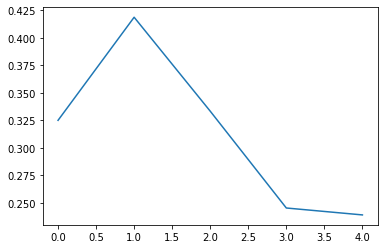

In [25]:
cvl = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index,:], X[test_index,:]
    Y_train, Y_test = Y[train_index], Y[test_index]
#     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
#     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
    cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    print('loss {}'.format(cvl[-1]))
plt.plot(cvl)

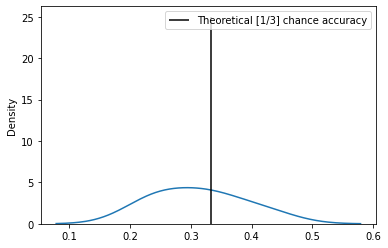

In [26]:
cross_validation_scores = cvl
sns.kdeplot(cvl)
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
plt.legend()


Training 0, loss: 0.3207547068595886

Training 1, loss: 0.3459119498729706

Training 2, loss: 0.2515723407268524

Training 3, loss: 0.3207547068595886

Training 4, loss: 0.3836477994918823

Training 5, loss: 0.37106919288635254

Training 6, loss: 0.24528302252292633

Training 7, loss: 0.31446540355682373

Training 8, loss: 0.276729553937912

Training 9, loss: 0.36477985978126526


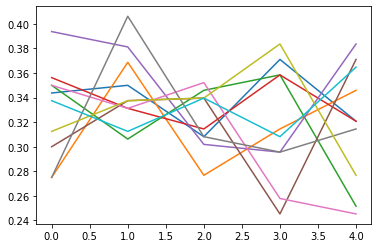

In [27]:
N_perm = 10
chance_cvl = []
for i in range(N_perm):
    print()
    cvl = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index,:], X[test_index,:]
        Y_ = np.random.permutation(Y)
        Y_train, Y_test = Y_[train_index], Y_[test_index]
    #     print("TRAIN:", X_train.shape, "TEST:", X_test.shape)
    #     print("TRAIN:", Y_train.shape, "TEST:", Y_test.shape)
        cvl.append(train_model(X_train, Y_train, X_test, Y_test))
    plt.plot(cvl)
    print(f"Training {i}, loss: {cvl[-1]}")
    chance_cvl.append(cvl)

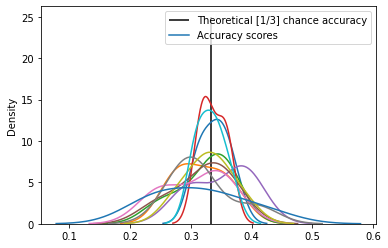

In [28]:
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
for i in chance_cvl:
    sns.kdeplot(i)
sns.kdeplot(cross_validation_scores, label="Accuracy scores")
plt.legend()

In [29]:
chance_scores = np.array(chance_cvl).reshape(-1)
chance_scores

array([0.34375   , 0.35      , 0.3081761 , 0.3710692 , 0.3207547 ,
       0.275     , 0.36875   , 0.27672955, 0.3144654 , 0.34591195,
       0.35      , 0.30625   , 0.34591195, 0.35849056, 0.25157234,
       0.35625   , 0.33125   , 0.3144654 , 0.35849056, 0.3207547 ,
       0.39375   , 0.38125   , 0.3018868 , 0.2955975 , 0.3836478 ,
       0.3       , 0.3375    , 0.33962265, 0.24528302, 0.3710692 ,
       0.35      , 0.33125   , 0.35220125, 0.25786164, 0.24528302,
       0.275     , 0.40625   , 0.3081761 , 0.2955975 , 0.3144654 ,
       0.3125    , 0.3375    , 0.33962265, 0.3836478 , 0.27672955,
       0.3375    , 0.3125    , 0.33962265, 0.3081761 , 0.36477986],
      dtype=float32)

In [30]:
cross_validation_scores = np.array(cross_validation_scores)
cross_validation_scores

array([0.325     , 0.41875   , 0.33333334, 0.24528302, 0.2389937 ],
      dtype=float32)

In [31]:
conf_int = np.quantile(chance_scores, 0.95)
print(conf_int)

0.3836477994918823


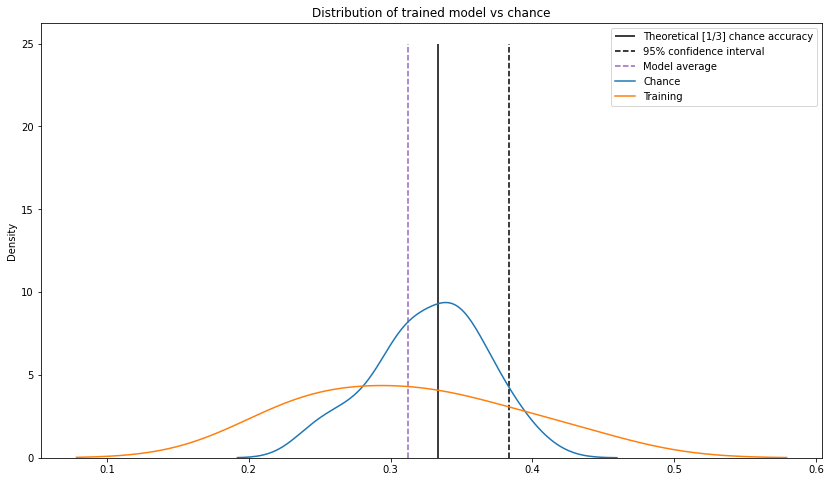

In [32]:
fig = plt.figure(figsize=(14,8))
plt.vlines([1/3], 0, 25, colors='k', linestyles='solid', label='Theoretical [1/3] chance accuracy')
plt.vlines([conf_int], 0, 25, colors='k', linestyles='dashed', label='95% confidence interval')
plt.vlines([cross_validation_scores.mean()], 0, 25, colors='C4', linestyles='dashed', label='Model average')
sns.kdeplot(chance_scores, label="Chance")
sns.kdeplot(cross_validation_scores, label="Training")
plt.title("Distribution of trained model vs chance")
plt.legend()

In [33]:
from scipy.stats import mannwhitneyu, ttest_ind
U, p = mannwhitneyu(chance_scores, cross_validation_scores)
print(U, p)

151.0 0.4550503857534919


In [34]:
t, p = ttest_ind(chance_scores, cross_validation_scores)
print(t, p)

0.7544088354246586 0.45394282123525553
